In [1]:
import os
import time
import librosa
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange,tqdm


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearnex import patch_sklearn, config_context

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('E:\Data')

In [3]:
path = os.getcwd() + "/chroma_60k_12_features/"
path

'E:\\Data/chroma_60k_12_features/'

In [4]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

print(TRAINING_DIR)
print(VALIDATION_DIR)
print(TEST_DIR)

E:\Data/chroma_60k_12_features//train
E:\Data/chroma_60k_12_features//val
E:\Data/chroma_60k_12_features//test


In [5]:
def data_loader(path):
    X = []
    Y = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            feature = np.load(os.path.join(path, folder, file))
            label = folder
            X += feature.tolist()
            Y += [label]*feature.shape[0]
    return X, Y

In [6]:
X_train, Y_train = data_loader(TRAINING_DIR)
X_val, Y_val = data_loader(VALIDATION_DIR)
X_test, Y_test = data_loader(TEST_DIR)

In [7]:
print("There are {} training samples and {} training labels".format(len(X_train), len(Y_train)))
print("There are {} validation samples and {} validation labels".format(len(X_val), len(Y_val)))
print("There are {} testing samples and {} testing labels".format(len(X_test), len(Y_test)))

There are 39999 training samples and 39999 training labels
There are 10000 validation samples and 10000 validation labels
There are 10000 testing samples and 10000 testing labels


In [8]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_val: {}".format(Y_val.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (39999, 12)
Shape of X_val: (10000, 12)
Shape of X_test: (10000, 12)
Shape of Y_train: (39999,)
Shape of Y_val: (10000,)
Shape of Y_test: (10000,)


In [9]:
X_test = np.vstack((X_test, X_val))
Y_test = np.hstack((Y_test, Y_val))
Y_train = Y_train.reshape((Y_train.shape[0], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))


print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (39999, 12)
Shape of X_test: (20000, 12)
Shape of Y_train: (39999, 1)
Shape of Y_test: (20000, 1)


In [10]:
X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [11]:
# shuffle_index = np.random.permutation(len(X_train))
# X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]
# shuffle_index = np.random.permutation(len(X_test))
# X_test, Y_test = X_test[shuffle_index], Y_test[shuffle_index]

In [12]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)
np.unique(Y_test)

array([0, 1])

In [13]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
print(X_train.shape)
print(X_train[0:5,:])

(39999, 12)
[[ 0.39986027  0.7933762   0.61389019 -0.38971229 -0.50017913 -0.37649847
  -0.20400853  0.11902565  0.32563654  0.33383537  0.42334619  0.43906734]
 [-0.55125176 -0.12925005  0.32985006 -0.22995045 -0.45203312  0.23720143
   1.76392175  2.21776745  1.21794719  0.09097475 -0.73019814 -1.11696503]
 [ 1.16152175  0.47446032  0.25906628 -0.75794726 -1.28490814 -1.17973621
  -0.9574197  -1.03183724 -0.95794242 -1.21061707 -0.08225178  2.28991972]
 [-0.51864336 -1.458665   -1.69910303 -1.58191399 -1.12210118 -0.80413329
  -0.80244453 -0.46525139 -0.03741061  2.72302728  3.0500335   0.62990488]
 [ 1.37666831  0.76607338  0.62541491 -0.22144271 -0.87128177 -0.7729084
  -0.7048703  -0.56229015 -0.79078588 -0.64690844 -0.03172315  0.49500368]]


In [14]:
SEED = 1337

In [15]:
classifiers = [['SVC',SVC(probability = True, random_state=SEED)],
                ['ExtraTreesClassifier', ExtraTreesClassifier(random_state=SEED)],
                ['LogisticRegression', LogisticRegression(random_state=SEED)],
              ['KNeighborsClassifier', KNeighborsClassifier()],
              ['RandomForestClassifier', RandomForestClassifier(random_state=SEED)],
                ['XGBClassifier', XGBClassifier(random_state=SEED)]]

In [16]:
def plot_roc_curve(Y_test, Y_pred_proba, name, title):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba[:,1])

    aucc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label="{0} (a = {1:.2f})".format(name.replace("Classifier", ""), aucc))
    plt.plot([0, 1], [0, 1], linestyle="dashed")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(title + ".png")
    # plt.show()

def plot_confusion_matrix(cm, title):
    df_cm = pd.DataFrame(cm, index = [i for i in ['Queen', 'Queenless']],
                    columns = [i for i in ['Queen', 'Queenless']])
    df_cm_normed = df_cm/df_cm.sum()
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="", )
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + '.png')
    plt.show()

In [17]:
patch_sklearn()

def evaluate_classifiers(classifiers):
    models = []
    Accuracy_set = pd.DataFrame(index=None, columns=['Model','Accuracy(Train)','Accuracy(Test)','F1(Train)','F1(Test)', 'Precision(Train)','Precision(Test)', 'Recall(Train)','Recall(Test)', 'Log_loss(Train)','Log_loss(Test)', 'Train_Time(s)', 'Confusion_Matrix(Test)'])
    for i in tqdm(range(len(classifiers))):
        name = classifiers[i][0]
        model = classifiers[i][1]
        time_start = time.time()
        model.fit(X_train,Y_train)
        time_end = time.time()
        

        Y_train_predicted = model.predict(X_train)
        Y_test_predicited = model.predict(X_test)
        Y_test_predict_proba = model.predict_proba(X_test)
        plot_roc_curve(Y_test, Y_test_predict_proba, name, "STFT Chroma features with Machine Learning Algorithms Roc-Curve")

        accuracy_train = accuracy_score(Y_train, Y_train_predicted)
        accuracy_test = accuracy_score(Y_test, Y_test_predicited)

        f1_Score_train = f1_score(Y_train, Y_train_predicted,average='micro')
        f1_Score_test = f1_score(Y_test, Y_test_predicited,average='micro')

        precision_score_train = precision_score(Y_train, Y_train_predicted,average='micro')
        precision_score_test = precision_score(Y_test, Y_test_predicited,average='micro')

        recall_score_train = recall_score(Y_train, Y_train_predicted,average='micro')
        recall_score_test = recall_score(Y_test, Y_test_predicited,average='micro')

        log_loss_train = log_loss(Y_train, model.predict_proba(X_train))
        log_loss_test = log_loss(Y_test, model.predict_proba(X_test))
        
        cf_matrix = confusion_matrix(Y_test, Y_test_predicited)

        train_time = time_end - time_start
        
        # store the models
        models.append((name,accuracy_test,model))

        Accuracy_set = Accuracy_set.append(pd.Series({'Model':name, 'Accuracy(Train)':accuracy_train,'Accuracy(Test)':accuracy_test,'F1(Train)':f1_Score_train,'F1(Test)':f1_Score_test,'Precision(Train)':precision_score_train,'Precision(Test)':precision_score_test,'Recall(Train)':recall_score_train,'Recall(Test)':recall_score_test,'Log_loss(Train)':log_loss_train,'Log_loss(Test)':log_loss_test,'Train_Time(s)':train_time, 'Confusion_Matrix(Test)':cf_matrix}),ignore_index=True)
    return Accuracy_set, models

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


  0%|          | 0/6 [00:00<?, ?it/s]

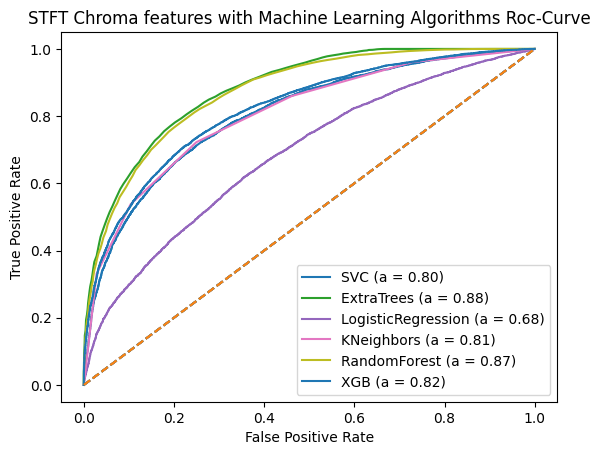

In [18]:
Accuracy_set, models = evaluate_classifiers(classifiers)

In [19]:
Accuracy_set.sort_values(by='Accuracy(Test)').style.background_gradient(cmap= plt.cm.Blues)

,Model,Accuracy(Train),Accuracy(Test),F1(Train),F1(Test),Precision(Train),Precision(Test),Recall(Train),Recall(Test),Log_loss(Train),Log_loss(Test),Train_Time(s),Confusion_Matrix(Test)
2,LogisticRegression,0.627091,0.628300,0.627091,0.628300,0.627091,0.628300,0.627091,0.628300,0.637965,0.637243,0.026958,[[6877 3123] [4311 5689]]
0,SVC,0.733368,0.730650,0.733368,0.730650,0.733368,0.730650,0.733368,0.730650,0.533541,0.538478,452.515677,[[7655 2345] [3042 6958]]
3,KNeighborsClassifier,0.827046,0.736450,0.827046,0.736450,0.827046,0.736450,0.827046,0.736450,0.355362,1.642334,0.063371,[[7504 2496] [2775 7225]]
5,XGBClassifier,0.830946,0.741950,0.830946,0.741950,0.830946,0.741950,0.830946,0.741950,0.405286,0.518242,2.195708,[[7659 2341] [2820 7180]]
4,RandomForestClassifier,1.000000,0.782550,1.000000,0.782550,1.000000,0.782550,1.000000,0.782550,0.132902,0.460866,21.057323,[[8121 1879] [2470 7530]]
1,ExtraTreesClassifier,1.000000,0.789550,1.000000,0.789550,1.000000,0.789550,1.000000,0.789550,0.000000,0.430876,4.933157,[[7978 2022] [2187 7813]]


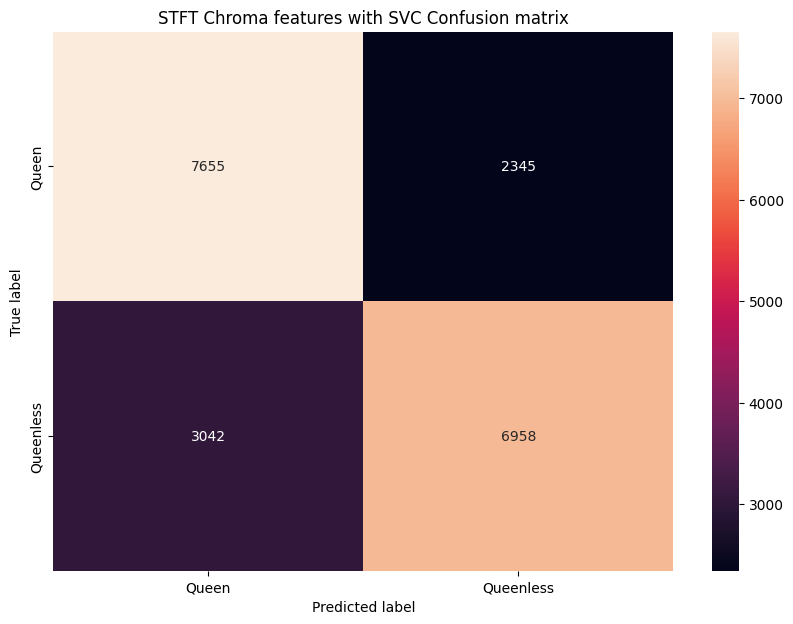

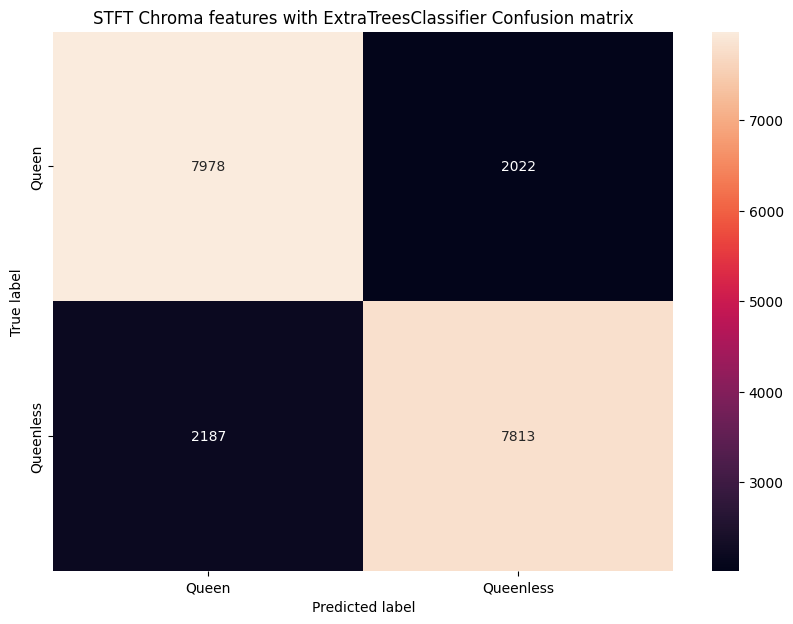

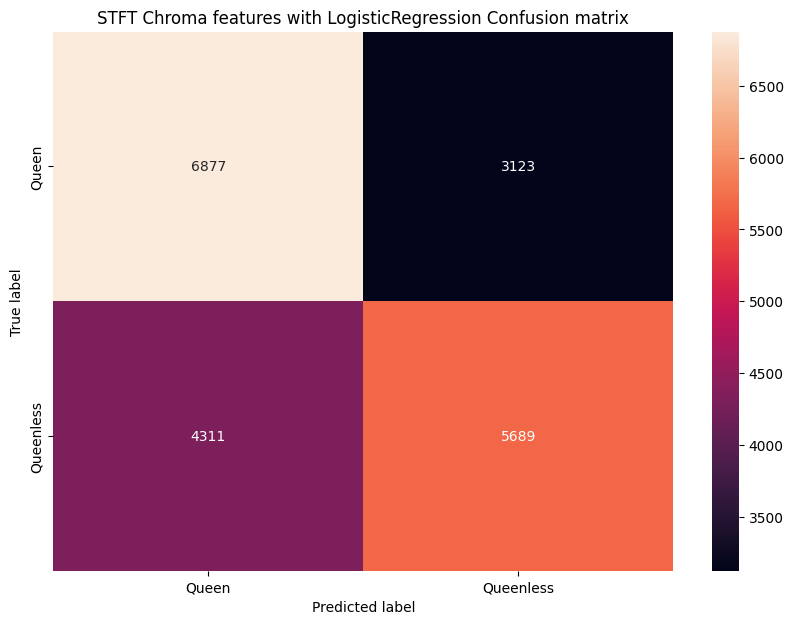

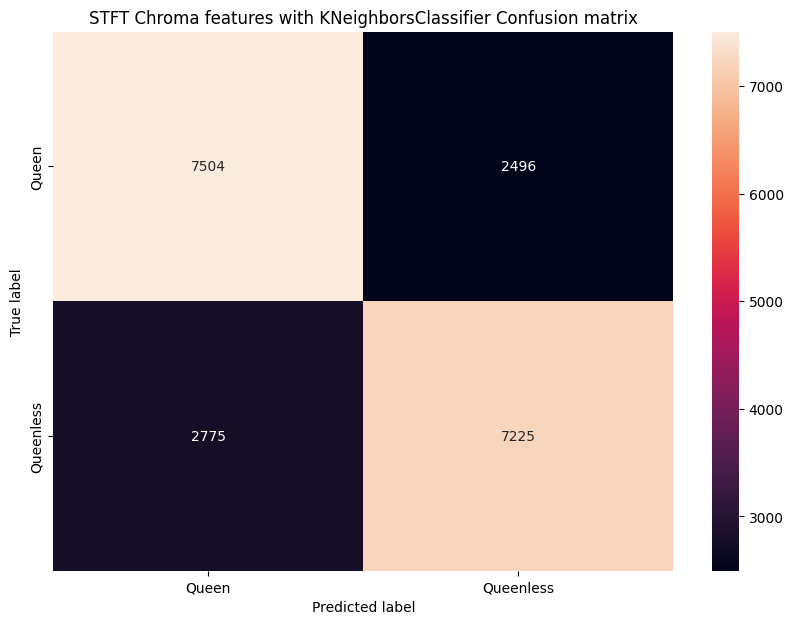

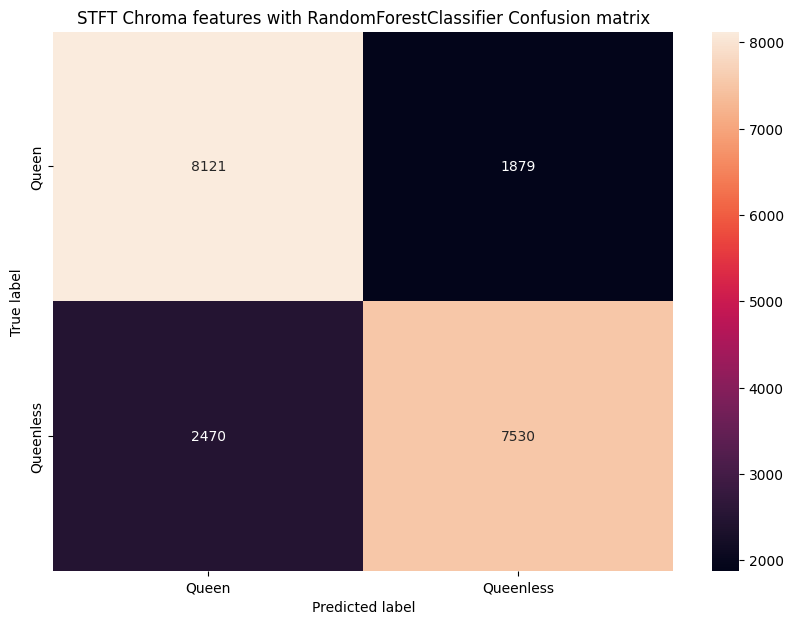

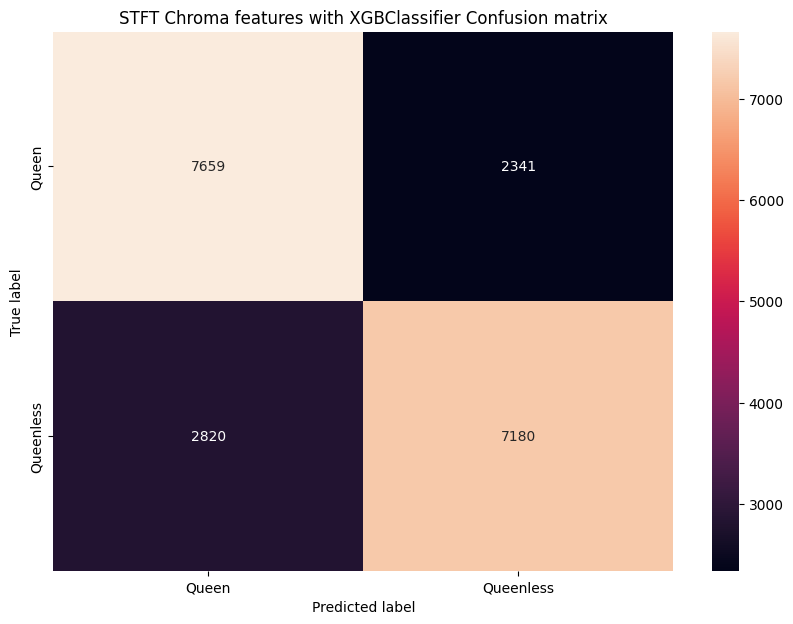

In [20]:
for index in range(len(Accuracy_set['Accuracy(Test)'])):
    plot_confusion_matrix(Accuracy_set['Confusion_Matrix(Test)'][index], "STFT Chroma features with {} Confusion matrix".format(Accuracy_set['Model'][index]))
    

In [21]:
os.chdir('D:\Study\Code\AI\Sound_Classification_Bee_Qeen_Queenless\model')
import pickle
for index in range(len(models)):
    model_name = models[index][0]
    model = models[index][-1]
    pickle.dump(model, open('Chroma_' + model_name + '.pkl', 'wb'))